In [1]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_images(img1,img2,title1="",title2="",figure_size = [15,15]):
    fig = plt.figure(figsize=figure_size)
    axis1 = fig.add_subplot(1,2,1)
    axis1.set(xticks=[],yticks=[],title=title1)
    axis1.imshow(img1,cmap="gray")

    axis2 = fig.add_subplot(1,2,2)
    axis2.set(xticks=[],yticks=[],title=title2)
    axis2.imshow(img2,cmap="gray")



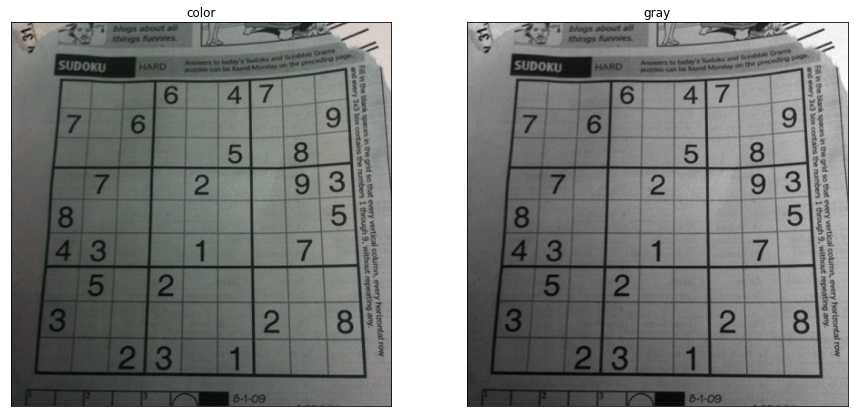

In [3]:
img = cv2.imread("./datasets/sudoku1.jpg")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

plot_images(img,gray_img,"color","gray")

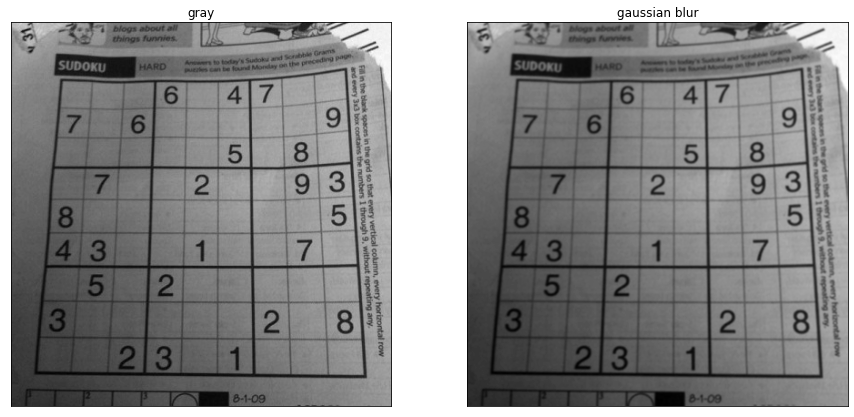

In [4]:
blurred_img = cv2.GaussianBlur(gray_img,(3,3),0)

plot_images(gray_img,blurred_img,"gray","gaussian blur")

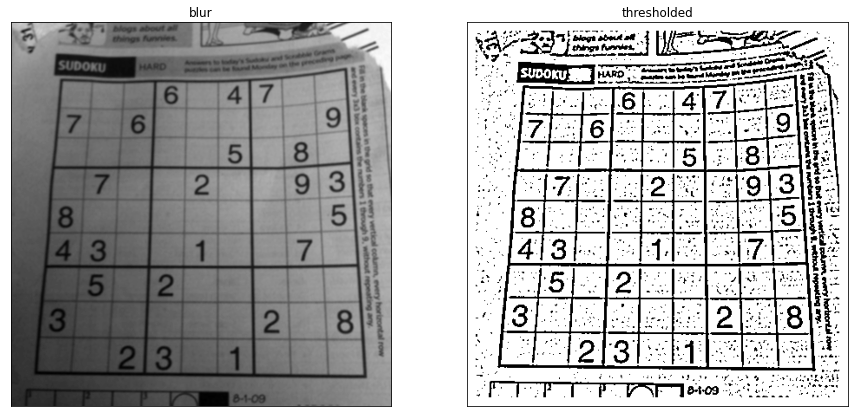

In [5]:
thresh_image = cv2.adaptiveThreshold(blurred_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,9,2)
thresh_image = cv2.copyMakeBorder(thresh_image.copy(),10,10,10,10,cv2.BORDER_CONSTANT,value=[255,255,255])
plot_images(blurred_img,thresh_image,"blur","thresholded")

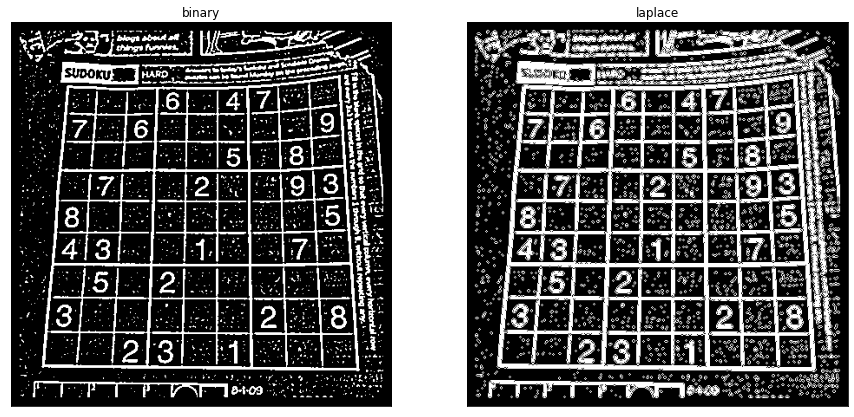

In [6]:
inverted_img = cv2.bitwise_not(thresh_image)
laplace_kernel = np.array([[0,1,0],[1,-2,1],[0,1,0]],np.int)

laplace_img = cv2.filter2D(inverted_img,-1,laplace_kernel)
plot_images(inverted_img,laplace_img,"binary","laplace")

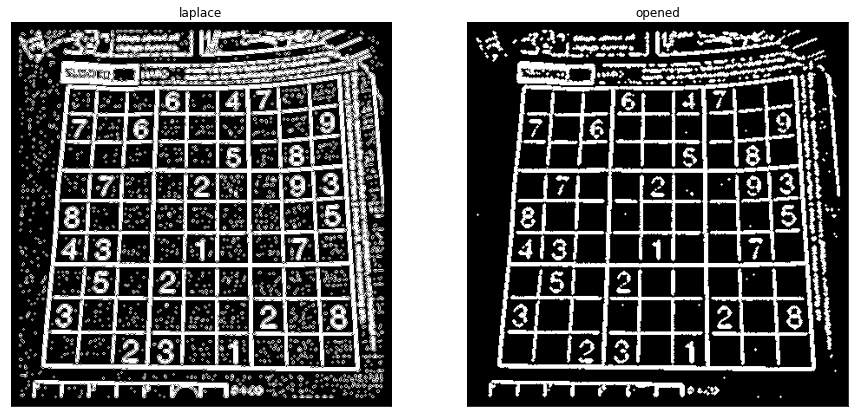

In [7]:
# erode_kernel = np.ones((3,3),np.uint8)
erode_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
#erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# eroded_img = cv2.erode(laplace_img,erode_kernel,iterations = 1)
opened_img = cv2.morphologyEx(laplace_img,cv2.MORPH_OPEN,erode_kernel)
plot_images(laplace_img,opened_img,"laplace","opened")

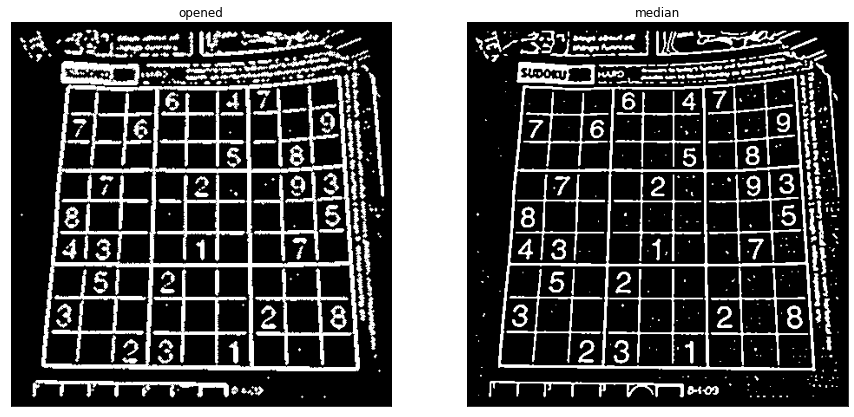

In [8]:
median_img = cv2.medianBlur(inverted_img,3)
plot_images(opened_img,median_img,"opened","median")

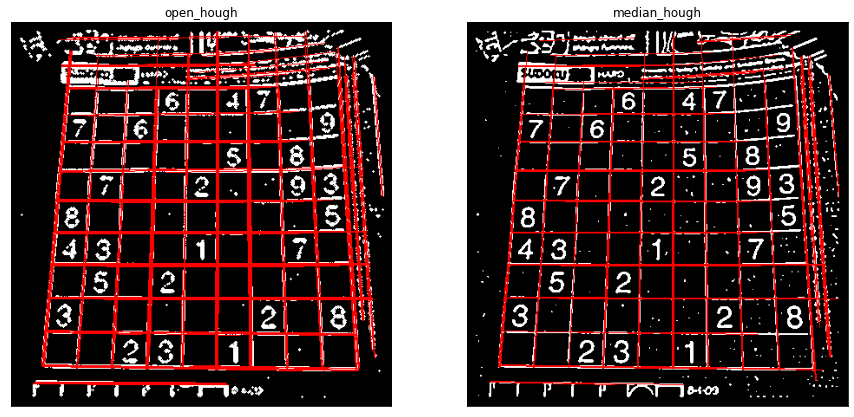

In [9]:
#testing hough lines with opened and median image, hough lines added to reinforce the lines by adding them on the original image

open_hough_lines = cv2.HoughLinesP(opened_img,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
median_hough_lines = cv2.HoughLinesP(median_img,1,np.pi/180,100,minLineLength=100,maxLineGap=10)

open_hough_image = cv2.cvtColor(opened_img.copy(),cv2.COLOR_GRAY2BGR)
for line in open_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(open_hough_image,(x1,y1),(x2,y2),(255,0,0),1)

median_hough_image = cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR)
for line in median_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(median_hough_image,(x1,y1),(x2,y2),(255,0,0),1)

plot_images(open_hough_image,median_hough_image,"open_hough","median_hough")

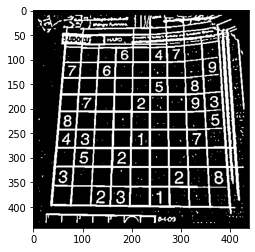

In [10]:
#selecting the median_hough image
median_hough_image = cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR)
for line in median_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(median_hough_image,(x1,y1),(x2,y2),(255,255,255),2)

median_hough_image = cv2.cvtColor(median_hough_image,cv2.COLOR_BGR2GRAY)
plt.imshow(median_hough_image,cmap="gray")

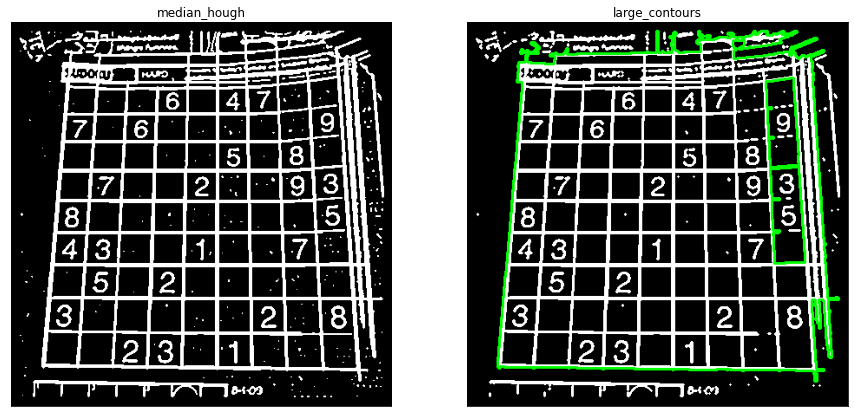

In [11]:
erode_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
#erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
#eroded_img = cv2.erode(median_hough_image,erode_kernel,iterations = 1)
eroded_image = cv2.morphologyEx(median_hough_image,cv2.MORPH_OPEN,erode_kernel)

contours,_ = cv2.findContours(eroded_image.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
large_contours = sorted(contours,key=cv2.contourArea,reverse=True)[:3]

contour_img = cv2.drawContours(cv2.cvtColor(eroded_image.copy(),cv2.COLOR_GRAY2BGR),large_contours,-1,(0,255,0),2)
plot_images(median_hough_image,contour_img,"median_hough","large_contours")
#retireve largest contour

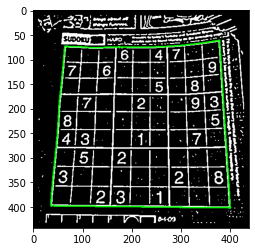

In [12]:

#so the hough transform is adding unnecessary horizontal lines, so its better to apply the contour first on the inverted threshold and then extract the largest shape by subtracting it from the background

contours,_ = cv2.findContours(median_img.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
large_contours = sorted(contours,key=cv2.contourArea,reverse=True)[:1]

contour_img = cv2.drawContours(cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR),large_contours,-1,(0,255,0),2)
plt.imshow(contour_img,cmap="gray")

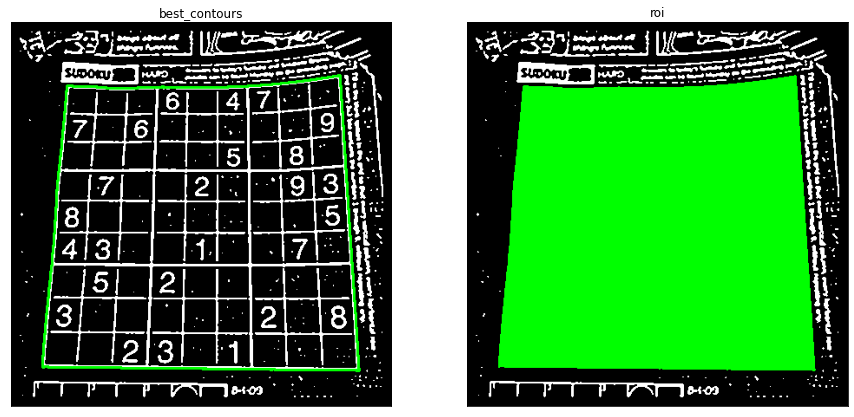

In [13]:

roi_image = cv2.cvtColor(median_img.copy(),cv2.COLOR_GRAY2BGR)
roi_contour = None
for c in large_contours:
    perimeter = cv2.arcLength(c,True)
    sides = cv2.approxPolyDP(c,0.02*perimeter,True)
    if len(sides) == 4:
        roi_contour = c
        cv2.drawContours(roi_image,[c],0,(0,255,0),thickness=cv2.FILLED)
        break

plot_images(contour_img,roi_image,"best_contours","roi")

(443, 439)


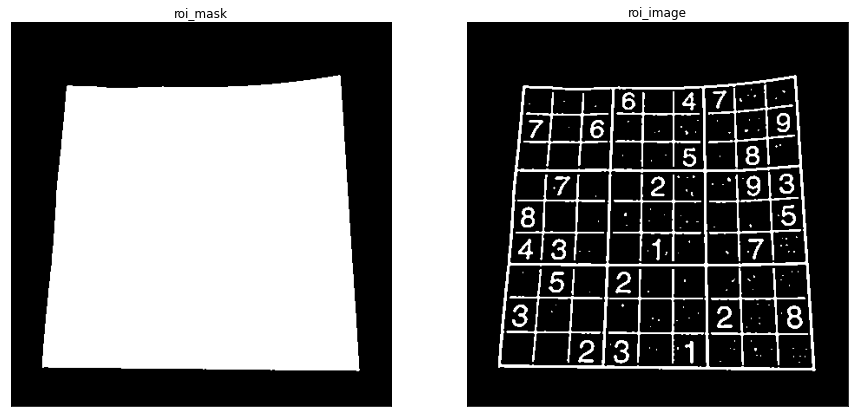

In [14]:
print(median_img.shape)
roi_mask = np.zeros(median_img.shape,np.uint8)
cv2.drawContours(roi_mask,[roi_contour],0,1,-1)

roi_image = cv2.bitwise_and(median_img,median_img,mask=roi_mask)

plot_images(roi_mask,roi_image,"roi_mask","roi_image")


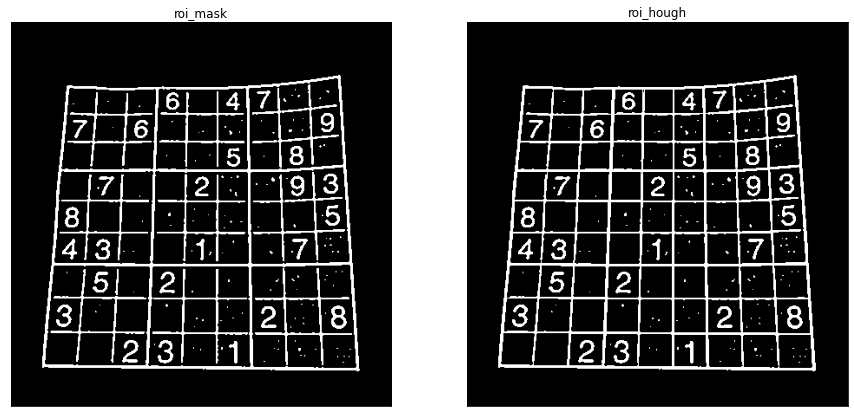

In [15]:
#trying to fix / smoothing the edges by overlaying the hough lines on the edges -> did not work but can be used to complete the lines

# bounding_box = np.zeros(roi_mask.shape,np.uint8)
# cv2.drawContours(bounding_box,[roi_contour],0,1,1)
#plt.imshow(bounding_box,cmap="gray")

roi_hough_lines = cv2.HoughLinesP(roi_image,1,np.pi/180,100,minLineLength=100,maxLineGap=15)
roi_hough_image = cv2.cvtColor(roi_image,cv2.COLOR_GRAY2BGR)
# plt.imshow(roi_hough_img,cmap="gray")
for line in roi_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(roi_hough_image,(x1,y1),(x2,y2),(255,255,255),1)

plot_images(roi_image,roi_hough_image,"roi_mask","roi_hough")

max 9.825325e-10
[9.5770203e-10 9.2651375e-10 8.9385882e-10 9.6934272e-10 9.8253250e-10
 8.9692725e-10 9.6328889e-10 9.7369979e-10]


(array([ 63,  64,  75, 395, 396, 396, 399, 399, 400, 400], dtype=int64),
 array([377, 377,  66,  38,  37,  38, 398, 399, 398, 399], dtype=int64))

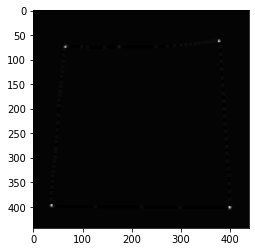

In [16]:
#detect the corners on the mask
corners = None
# smooth_edge_image = cv2.medianBlur(bounding_box,3)
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(roi_mask, cv2.MORPH_CLOSE, kernel)
corner_image = cv2.cornerHarris(opening,7,5,0.01)
plt.imshow(corner_image,cmap="gray")
max_corner_intensity = corner_image.max()
print("max",max_corner_intensity)
print(corner_image[corner_image > 0.90*max_corner_intensity])

corners = np.where(corner_image > 0.85* max_corner_intensity)
corners

#difficulty in processing results using Harris, multiple corners being detected

[ 36 398 400 401 378  62  65  74]


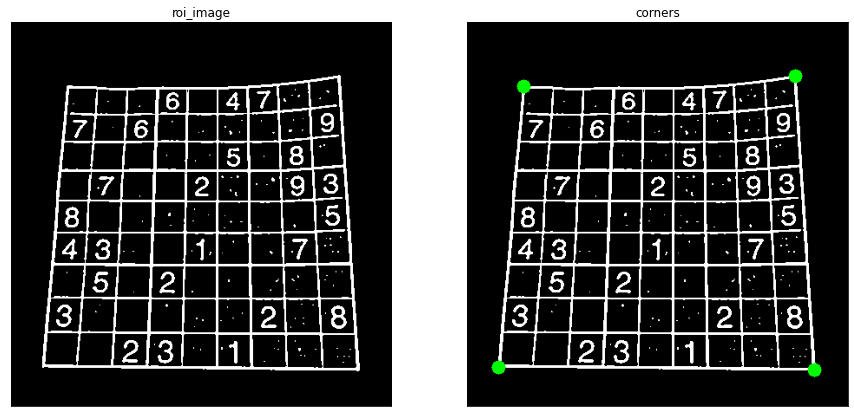

In [17]:
#corners using Shi Tomasi as it allows specifying the minimum distance between corners
corners = cv2.goodFeaturesToTrack(roi_mask,4,0.01,25)
corners = np.int0(corners)
print(corners.ravel())

# corner_image = cv2.cvtColor(roi_hough_image,cv2.COLOR_GRAY2BGR)
corner_image = roi_hough_image.copy()
for corner in corners:
    x,y = corner.ravel()
    cv2.circle(corner_image,(x,y),8,(0,255,0),-1)

plot_images(roi_hough_image,corner_image,"roi_image","corners")

In [18]:

img_width,img_height = 500,500
img_width,img_height

unwrap_corner_points = [[0,0],[img_width,0],[0,img_height],[img_width,img_height]]

corner_points = [[corner.ravel()[0],corner.ravel()[1]] for corner in corners]
print(corner_points)
#find points closest to each corner for the perspective transform
original_corner_points = []
for ucp in unwrap_corner_points:
     #min_manhattan_dist = list(map(lambda point: abs(point[0] - ucp[0]) + abs(point[1] - ucp[1])  ,corner_points))
     min_manhattan_dist = list(map(lambda point: math.sqrt((point[0] - ucp[0])**2 + (point[1] - ucp[1])**2)  ,corner_points))
     original_corner_points.append(corner_points[min_manhattan_dist.index(min(min_manhattan_dist))])

original_corner_points

[[36, 398], [400, 401], [378, 62], [65, 74]]


[[65, 74], [378, 62], [36, 398], [400, 401]]

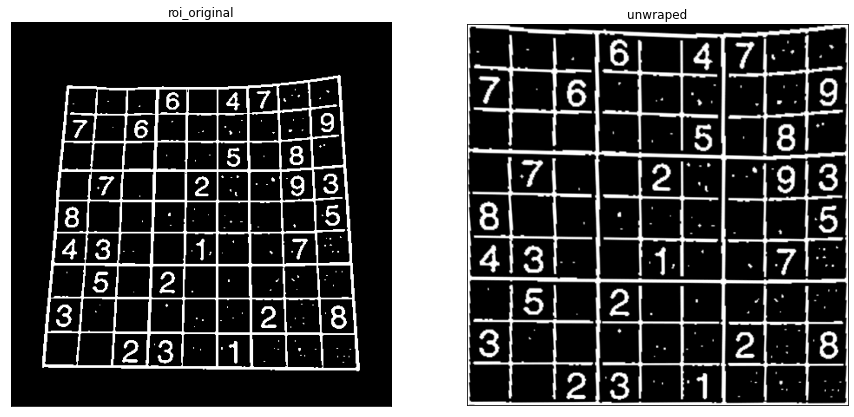

In [19]:
#perspective transform
unwrap_corner_points = np.float32(unwrap_corner_points)
original_corner_points = np.float32(original_corner_points)
transform_matrix = cv2.getPerspectiveTransform(original_corner_points,unwrap_corner_points)

unwraped_image = cv2.warpPerspective(roi_image,transform_matrix,(img_height,img_width))

#original image to write back to


plot_images(roi_hough_image,unwraped_image,"roi_original","unwraped")

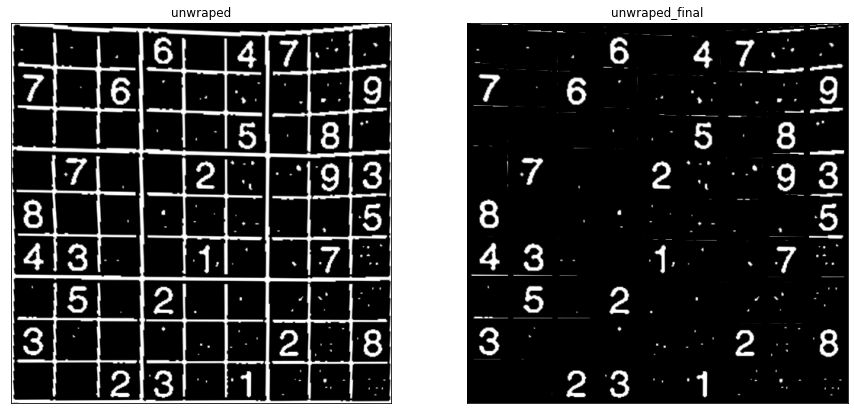

In [20]:
#trying to remove the lines using houhg transform
unwrap_hough_lines = cv2.HoughLinesP(unwraped_image,1,np.pi/180,200,minLineLength=150,maxLineGap=20)
#roi_hough_image = cv2.cvtColor(roi_image,cv2.COLOR_GRAY2BGR)
unwrap_final = unwraped_image.copy()
# plt.imshow(roi_hough_img,cmap="gray")
for line in unwrap_hough_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(unwrap_final,(x1,y1),(x2,y2),(0,0,0),2)

#unwrap_final = cv2.medianBlur(unwrap_final.copy(),5)
erode_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
dilate_kernel = np.ones((5,5),np.uint8)
# unwrap_final = cv2.morphologyEx(unwrap_final, cv2.MORPH_OPEN, kernel)
unwrap_final = cv2.morphologyEx(unwrap_final, cv2.MORPH_CLOSE, erode_kernel)
#unwrap_final = cv2.erode(unwrap_final.copy(),erode_kernel,iterations=1)
#unwrap_final = cv2.dilate(unwrap_final.copy(),erode_kernel,iterations=1)
#unwrap_final = cv2.morphologyEx(unwrap_final, cv2.MORPH_CLOSE, erode_kernel)
plot_images(unwraped_image,unwrap_final,"unwraped","unwraped_final")

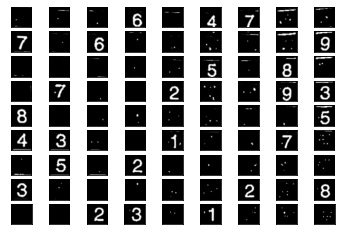

In [21]:
unwrap_final = cv2.resize(unwrap_final,(512,512))
# plt.imshow(unwraped_image,cmap="gray")

imgheight=unwrap_final.shape[0]
imgwidth=unwrap_final.shape[1]

box_size = imgheight//9 + 1

number_tiles = []

for y in range(0,imgheight,box_size):
    for x in range(0,imgwidth,box_size):
        tile = unwrap_final[y:y+box_size,x:x+box_size].copy()
        # print(tile.shape)
        number_tiles.append((tile,None))

#number_tiles = np.array(number_tiles,np.uint8)
# np.shape(number_tiles)
def print_num_grid(rows,cols,img_tiles):

    splited_figures = plt.figure()
    axes = [splited_figures.add_subplot(rows,cols,r*rows+c + 1) for r in range(rows) for c in range(cols)]

    for i,ax in enumerate(axes):
        ax.imshow(img_tiles[i][0],cmap="gray")
        ax.set(xticks=[],yticks=[])

print_num_grid(9,9,number_tiles)


In [36]:
#extract one number to deal with it
print(number_tiles[17][0].shape)
img_to_file = cv2.resize(number_tiles[17][0],(32,32))
cv2.imwrite("no9.png",img_to_file)
#print(number_tiles[49].shape,img_to_file.shape)

(57, 56)


True

(32, 32)

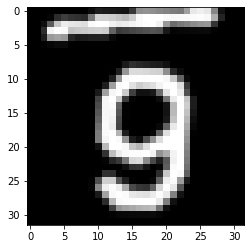

In [37]:
number_img = cv2.imread("no9.png",0)
#number_img = cv2.resize(number_img,(28,28))
plt.imshow(number_img,cmap="gray")
number_img.shape



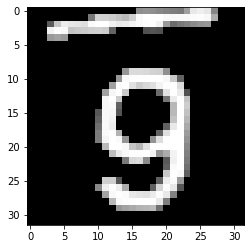

In [38]:
#number_img = cv2.medianBlur(number_img,1)
_,thresh_number = cv2.threshold(number_img,80,255,cv2.THRESH_TOZERO)
# kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
# thresh_number = cv2.erode(thresh_number,kernel,iterations=1)
#thresh_number = cv2.morphologyEx(thresh_number,cv2.MORPH_CLOSE,kernel)
#p = cv2.GaussianBlur(thresh_number,(3,3),0)
plt.imshow(thresh_number,cmap="gray")

(32, 32)
3
1.5
16 16
187.0


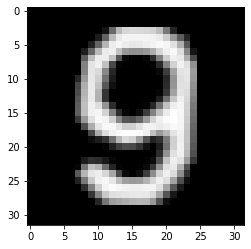

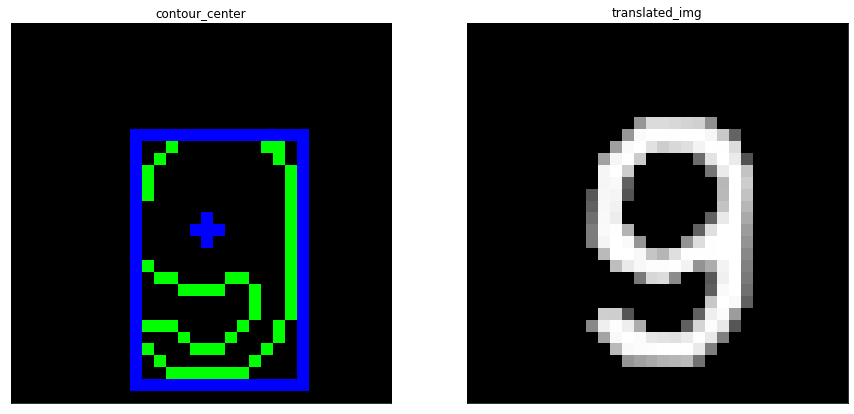

In [39]:
## experitmenting with image to get best possible outcome
#try moving the largest contour to the center of image
print(thresh_number.shape)
#thresh_number = cv2.cvtColor(thresh_number.copy(),cv2.COLOR_BGR2GRAY)
number_contours,_ = cv2.findContours(thresh_number,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(number_contours))

contour_number_img = np.zeros((thresh_number.shape[0],thresh_number.shape[1],3),np.int32)
number_contours = sorted(number_contours,key = cv2.contourArea,reverse=True)
#print(number_contours)
#print(cv2.contourArea(number_contours[0]))
if len(number_contours) > 0:
    contour_number_img = cv2.drawContours(contour_number_img,number_contours,0,(0,255,0),1)

    #apply mask to cut out largest contour
    mask = np.zeros(thresh_number.shape,np.uint8)
    cv2.drawContours(mask,number_contours,0,1,-1)

    thresh_number = cv2.bitwise_and(thresh_number,thresh_number,mask = mask)

    #try zooming in the number
    x,y,w,h = cv2.boundingRect(number_contours[0])
    contour_number_img = cv2.rectangle(contour_number_img,(x,y),(x+w,y+h),(0,0,255),1)
    cropped_image = thresh_number[y:y+h,x:x+w]
    h_w_ratio = h/w
    new_h = 26
    new_w = int(new_h/h_w_ratio)
    cropped_image = cv2.resize(cropped_image,(new_w,new_h))
    rem_h = 32 - new_h
    rem_w = max(32 - new_w,0)
    cropped_image = cv2.copyMakeBorder(cropped_image,rem_h//2,rem_h//2,rem_w//2,rem_w//2,cv2.BORDER_CONSTANT,0)
    cropped_image = cv2.resize(cropped_image,(32,32))
    print(h_w_ratio)

    #cropped_image = cv2.copyMakeBorder(cropped_image,1,1,4,4,cv2.BORDER_CONSTANT,0)
    plt.imshow(cropped_image,cmap="gray")


#check for pixels in center , this will handle any noisy edges that pass through after applying black hough lines
x1 = thresh_number.shape[1]//4
x2 = x1 + thresh_number.shape[1]//2
y1 = thresh_number.shape[0]//4
y2 = y1 + thresh_number.shape[0]//2
cropped_roi = thresh_number[x1:x2,y1:y2]
#plt.imshow(cropped_roi,cmap="gray")
white_pixels = cv2.countNonZero(cropped_roi)
total_pixels = cropped_roi.shape[0]*cropped_roi.shape[1]
intresting = white_pixels/total_pixels
center_number_image = None

if intresting >= 0.12:
    #proceed to center the image
    #finding center of mass

    largest_contour = number_contours[0]
    M = cv2.moments(largest_contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cv2.circle(contour_number_img,(cx,cy),1,(0,0,255),-1)
    #plt.imshow(contour_number_img,cmap="gray")

    im_cx = im_cy = thresh_number.shape[0]//2
    print(im_cx,im_cy)
    print(cv2.contourArea(largest_contour))
    #translate image
    translation_matrix = np.float32([[1,0,(im_cx - cx)],[0,1,im_cy - cy]])
    center_number_image = cv2.warpAffine(thresh_number,translation_matrix,thresh_number.shape)
    #center_number_image = cv2.GaussianBlur(center_number_image,(3,3),0)
    #_,center_number_image = cv2.threshold(center_number_image,80,255,cv2.THRESH_BINARY)
    plot_images(contour_number_img,center_number_image,"contour_center","translated_img",figure_size=[15,15])
else:
    center_number_image = np.zeros(thresh_number.shape,np.uint8)


In [26]:
#save image after applying masking for largest shape
cv2.imwrite("no9.png",cropped_image)

True

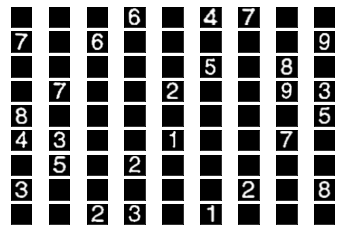

In [27]:
#preprocess images to center

processed_numbers = []
num_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)

for number_tile in number_tiles:
    num = number_tile[0]
    #num = cv2.cvtColor(num,cv2.COLOR_BGR2GRAY)
    #num = cv2.medianBlur(num,1)
    _,thresh_num = cv2.threshold(num,80,255,cv2.THRESH_TOZERO)
    #thresh_num = cv2.erode(thresh_num,num_kernel,iterations=1)
    num_contours,_ = cv2.findContours(thresh_num,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros((32,32),np.uint8)
    is_blank = True

    if(len(num_contours)>=1):
        num_contours = sorted(num_contours,key=cv2.contourArea,reverse=True)
        largest_contour = num_contours[0]
        if(cv2.contourArea(largest_contour)>=10):
            #creating mask for the ROI
            mask = np.zeros(thresh_num.shape,np.uint8)
            cv2.drawContours(mask,[largest_contour],0,1,-1)
            roi_img = cv2.bitwise_and(thresh_num,thresh_num,mask=mask)
            #extract bounding rectangle
            
            #contour_number_img = cv2.rectangle(contour_number_img,(x,y),(x+w,y+h),(0,0,255),1)
            # cropped_image = cv2.resize(cropped_image,(20,26))
            # roi_img = cv2.copyMakeBorder(cropped_image,1,1,4,4,cv2.BORDER_CONSTANT,0)
            #check center for blank image
            x1 = roi_img.shape[1]//4
            x2 = x1 + roi_img.shape[1]//2
            y1 = roi_img.shape[0]//4
            y2 = y1 + roi_img.shape[0]//2
            cropped_roi = roi_img[x1:x2,y1:y2]

            white_pixels = cv2.countNonZero(cropped_roi)
            total_pixels = cropped_roi.shape[0]*cropped_roi.shape[1]
            intresting = white_pixels/total_pixels

            if intresting >= 0.12:

                x,y,w,h = cv2.boundingRect(largest_contour)
                cropped_image = roi_img[y:y+h,x:x+w]
                h_w_ratio = h/w
                new_h = 26
                new_w = int(new_h/h_w_ratio)
                cropped_image = cv2.resize(cropped_image,(new_w,new_h))
                rem_h = 32 - new_h
                rem_w = max(32 - new_w,0)
                cropped_image = cv2.copyMakeBorder(cropped_image,rem_h//2,rem_h//2,rem_w//2,rem_w//2,cv2.BORDER_CONSTANT,0)
                cropped_image = cv2.resize(cropped_image,(32,32))
                roi_img = cropped_image
                #center the image
                # M = cv2.moments(largest_contour)
                # cx = int(M['m10']/M['m00'])
                # cy = int(M['m01']/M['m00'])
                # im_cx = im_cy = num.shape[0]//2
                # print("hello",end="")
                # translation_matrix = np.float32([[1,0,(im_cx - cx)],[0,1,im_cy - cy]])
                # centered_img = cv2.GaussianBlur(centered_img,(3,3),0)
                # _,centered_img = cv2.threshold(centered_img,80,255,cv2.THRESH_BINARY)
                is_blank = False
                result_img = roi_img
    
    processed_numbers.append((result_img,is_blank))
        


np.shape(processed_numbers)
print_num_grid(9,9,processed_numbers)

In [28]:
for img,is_blank in processed_numbers:
    print(is_blank,end=" ")

True True True False True False False True True False True False True True True True True False True True True True True False True False True True False True True False True True False False False True True True True True True True False False False True True False True True False True True False True False True True True True True False True True True True True False True False True True False False True False True True True 

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D

In [30]:
# initialize model
input_image_shape = (32,32,1)
num_classes = 9

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_image_shape))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.load_weights('./sudoku_number_model.h5')

In [31]:
#process and feed image to get output only where is_blank = False
sudoku_matrix = []

for digit_img,is_blank in processed_numbers:

    if is_blank:
        sudoku_matrix.append(0)
    else:
        #process image
        #_,digit_img = cv2.threshold(digit_img,100,255,cv2.THRESH_BINARY)
        #kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
        #digit_img = cv2.erode(digit_img,kernel,iterations=1)
        #kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
        #digit_img = cv2.erode(digit_img,kernel,iterations=1) 
        #digit_img = cv2.morphologyEx(digit_img,cv2.MORPH_CLOSE,kernel)   
        #digit_img = cv2.bitwise_not(digit_img)
        final_img = digit_img.reshape(-1,32,32,1)
        final_img = final_img.astype('float32')
        final_img = final_img/255
        prediction = model.predict([final_img])
        predicted_digit = np.argmax(prediction[0])+1
        sudoku_matrix.append(int(predicted_digit))

sudoku_matrix = np.reshape(sudoku_matrix,(9,9))
sudoku_matrix


array([[0, 0, 0, 6, 0, 4, 7, 0, 0],
       [7, 0, 6, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 0, 0, 5, 0, 8, 0],
       [0, 7, 0, 0, 2, 0, 0, 9, 3],
       [8, 0, 0, 0, 0, 0, 0, 0, 5],
       [4, 3, 0, 0, 1, 0, 0, 7, 0],
       [0, 5, 0, 2, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 2, 0, 8],
       [0, 0, 2, 3, 0, 1, 0, 0, 0]])

In [32]:
#solve_sudoku function in sudoku_backtrack.py file
import sudoku_backtrack_greedy

sudoku_backtrack_greedy.solve_sudoku(sudoku_matrix)

True

5  8  3  | 6  9  4  | 7  2  1
7  1  6  | 8  3  2  | 5  4  9
2  9  4  | 1  7  5  | 3  8  6
-----------------------------
6  7  1  | 5  2  8  | 4  9  3
8  2  9  | 7  4  3  | 1  6  5
4  3  5  | 9  1  6  | 8  7  2
-----------------------------
1  5  8  | 2  6  7  | 9  3  4
3  6  7  | 4  5  9  | 2  1  8
9  4  2  | 3  8  1  | 6  5  7



5
(500, 500, 3)
56


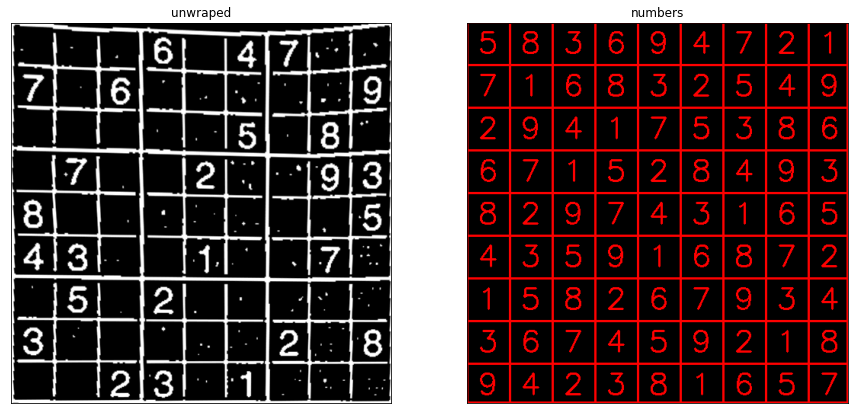

In [33]:
#writing grid back to image and construct original image
#unwraped image is the final one with the grid construct to write back to
#using a blank image
ouput_matrix = sudoku_matrix.reshape(-1)
print(ouput_matrix[0])
output_image = np.zeros((500,500,3),np.uint8)
print(output_image.shape)
#output_image = cv2.resize(output_image,(500,500))
box_size = 500//9 + 1

print(box_size)
curr_element = 0
for x in range(0,500,box_size):
    output_image = cv2.line(output_image,(x,0),(x,500),(255,0,0),2)
    for y in range(0,500,box_size):
        mid_x = x + box_size//2 + 12
        mid_y = y + box_size//4
        #print(x,y)
        output_image = cv2.line(output_image,(0,y),(500,y),(255,0,0),2)
        output_image = cv2.putText(output_image,str(ouput_matrix[curr_element]),(mid_y,mid_x),cv2.FONT_HERSHEY_SIMPLEX,1.3,(255,0,0),2,cv2.LINE_4)
        curr_element += 1

output_image = cv2.line(output_image,(499,0),(499,499),(255,0,0),2)
output_image = cv2.line(output_image,(0,499),(499,499),(255,0,0),2)
_,output_image = cv2.threshold(output_image,10,255,cv2.THRESH_BINARY)
plot_images(unwraped_image,output_image,"unwraped","numbers")





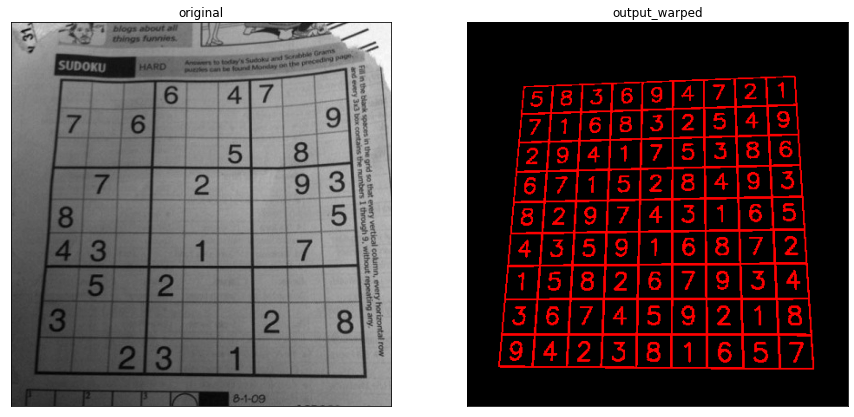

In [34]:
#print(original_corner_points)
#print(median_img.shape)
img_width,img_height,_ = output_image.shape
unwrap_corner_points = [[0,0],[img_width,0],[0,img_height],[img_width,img_height]]
#print(transform_matrix)

inverse_transform_matrix = np.linalg.inv(transform_matrix)
#print(inverse_transform_matrix)

# transform_matrix = cv2.getPerspectiveTransform(original_corner_points,unwrap_corner_points)
# unwraped_image = cv2.warpPerspective(roi_image,transform_matrix,(500,500))

output_wraped_img = cv2.warpPerspective(output_image,inverse_transform_matrix,(median_img.shape[1],median_img.shape[0]))
output_wraped_img[output_wraped_img>0] = 255
plot_images(gray_img,output_wraped_img,"original","output_warped")

#plt.imshow(cv2.bitwise_not(output_wraped_img),cmap="gray")

(443, 439, 3)
(443, 439, 3)
(443, 439, 1)


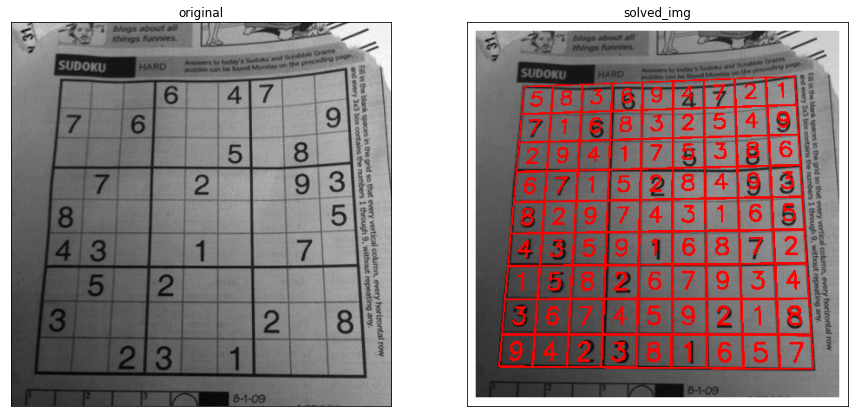

In [35]:
#output_wraped_img = cv2.bitwise_not(output_wraped_img)
#solved_img = cv2.addWeighted(cv2.cvtColor(gray_img,cv2.COLOR_GRAY2BGR),0.5,output_wraped_img,0.9,0)
gray_image = cv2.cvtColor(gray_img,cv2.COLOR_GRAY2BGR)
gray_image = cv2.copyMakeBorder(gray_image.copy(),10,10,10,10,cv2.BORDER_CONSTANT,value=[255,255,255])
print(output_wraped_img.shape)
print(gray_image.shape)

x = output_wraped_img.sum(axis=-1,keepdims=True)
print(x.shape)
#plt.imshow(x,cmap="gray")
solved_img = np.where(output_wraped_img.sum(axis=-1,keepdims=True)>10, output_wraped_img, gray_image)
# for i in range(output_wraped_img.shape[0]):
#     for j in range(output_wraped_img.shape[1]):
#         for k in range(output_wraped_img.shape[2]):
#             if output_wraped_img[i][j][k] > 0:
#                 #print(output_wraped_img[i][j])
#                 gray_image[i][j] = output_wraped_img[i][j]

#r = np.where(output_wraped_img == (0,255,0))
#print(r)
#print(r)
plot_images(gray_img,solved_img,"original","solved_img")